In [19]:
#@title Retrieve IRIS Dataset {display-mode: "form"}
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt

remove_first_class = True #@param ["True", "False"] {type: "raw"}

D, l = datasets.load_iris(return_X_y=True)

if remove_first_class:
  D = D[50:,:]
  l = l[50:]
  colors = {1: 'r', 2: 'b'}
  labels = [1, 2]
  print('We have removed the first class.')
else:
  colors = ['r', 'g', 'b']
  labels = [0, 1, 2]
  
D_reduced = PCA(n_components = 2).fit_transform(D)

We have removed the first class.


## Creating Weighted KNN Graph

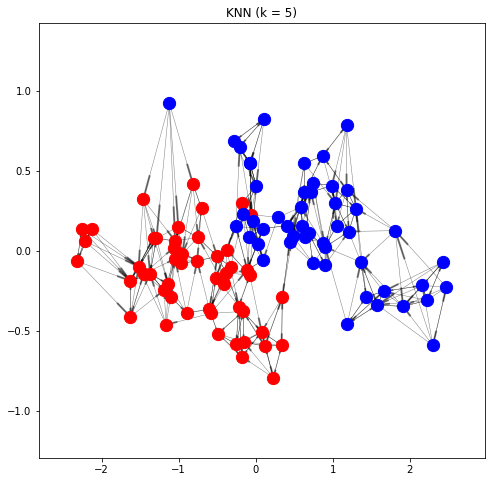

In [30]:
#@title Creating weighted KNN Graph {display-mode: "form"}
import numpy as np
import networkx as nx
from numpy import linalg as LA
from sklearn.neighbors import kneighbors_graph

k_neighbors = 5 #@param {type: "integer"}
use_reduced = False #@param ["True", "False"] {type:"raw"}

if use_reduced == False:
  A = kneighbors_graph(D, k_neighbors)
else:
  A = kneighbors_graph(D_reduced, k_neighbors)

rows, cols = A.nonzero()
for i in range(len(rows)):
  A[rows[i],cols[i]] = LA.norm(D[rows[i],:] - D[cols[i],:])

G = nx.from_scipy_sparse_matrix(A, create_using=nx.DiGraph())
node_label = {}

for v in G.node.keys():
    node_label[v] = str(l[v])
nx.set_node_attributes(G, 'class', node_label)

pos = {}
for i in range(D.shape[0]):
  pos[i] = (D_reduced[i,0], D_reduced[i,1])

margin = .5
x_min = D_reduced[:,0].min() - margin; x_max = D_reduced[:,0].max() + margin
y_min = D_reduced[:,1].min() - margin; y_max = D_reduced[:,1].max() + margin

plt.figure(num=None, figsize=(8,8))
node_size = 150
for label in labels:
  nx.draw_networkx_nodes(G, pos,
                        nodelist=np.where(l == label)[0].tolist(),
                        node_color=colors[label],
                        node_size=node_size)
nx.draw_networkx_edges(G, pos, alpha=.5, width=.5);

plt.xlim(x_min, x_max);
plt.ylim(y_min, y_max);

plt.title('KNN (k = %d)' % k_neighbors);

plt.show();

### WARNING
**_This is an $O(N^2)$ implementation of Dijkstra. Use Random Access Priority Queues for $O(N\log{N})$ Dijkstra_**

In [3]:
#@title Utility Functions (Incl'd: Narrowest Path Width) {display-mode: "form"}
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Filters a dictionary by a set of keys
def filter_dictionary_by(source, keys):  
  res = {}
  for key in keys:
    res[key] = source[key]
  return res

def filter_return_values(dic, keys):
  
  res = []
  for key in keys:
    res.append(dic[key])
  return res

def normalize_dictionary(d):
  
  max_value = float(max(d.values()))
  min_value = float(min(d.values()))
  
  for key, value in d.items():
    d[key] = (value - min_value) / (max_value - min_value)
    
  return d
  

def all_pairs_euclidean(Data, normalized=True):
  res = {}
  max_distance = -1.0
  for i in range(len(Data)):
    for j in range(len(Data)):
      res[(i,j)] = LA.norm(Data[i,:] - Data[j,:])
      max_distance = max(max_distance, res[(i,j)])
      
  if normalized == True:
    for pair, distance in res.items():
      res[pair] /= max_distance
  return res

def class_similarity(Lbl, source=None):  
  res = {}
  
  if source is None:
    # This is an all-pair class similarity
    for source in range(len(Lbl)):
      for other in range(len(Lbl)):
        res[(source, other)] = int(Lbl[source] == Lbl[other])
  else:
    for other in range(len(Lbl)):
      if source == other:
        continue
      res[(source, other)] = int(Lbl[source] == Lbl[other])
      
  return res

################################################################
# TODO: Make this a heap dijkstra instead of a O(N^2) dijkstra #
################################################################

# Function to find the narrowest path to all nodes from v
def narrowest_path_length(G, v):
  
  marked_nodes = set()
  final_dis = {}
  current_dis = {}
  for u in G.node.keys():
      current_dis[u] = float('inf')
  current_dis[v] = 0.0
  
  while len(current_dis) > 0:
    closest_node = -1
    closest_distance = float('inf')
    
    # Finding the closest node
    for u, distance in current_dis.items():
      if distance < closest_distance:
        closest_node = u
        closest_distance = distance
        
    if closest_node == -1:
      break
        
    # Selecting closest node for the final distance
    final_dis[(v,closest_node)] = closest_distance
    current_dis.pop(closest_node)
    marked_nodes.add(closest_node)
    
    # Updating closest node's neighbors
    for u, edge in G[closest_node].items():
      if u in marked_nodes:
        continue
      weight = edge['weight']
      current_dis[u] = min(
          # Keeping the path before
          current_dis[u],
          # Going through the 'closest node'
          max(closest_distance, weight)
      )
      
  # We remove self-distance, not a good piece of info
  final_dis.pop((v,v))
  
  return final_dis

### Narrowest Path Width (Length) Definition
For a path $\langle v_1, v_2, \cdots, v_k\rangle$, the path *width* would be
$\max{w(v_i, v_{i+1})}$. A path $\langle v_1, v_2, \cdots, v_k \rangle$ is the
narrowest path between $v_1$ and $v_k$ if it has minimum width among *all*
possible paths.

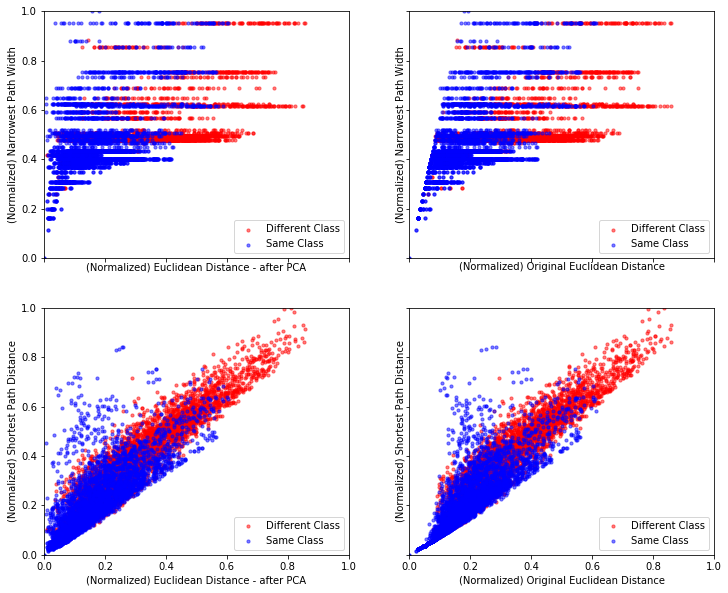

In [17]:
#@title Narrowest Path Width vs. Euclidean Distance {display-mode: "form"}
from sklearn.preprocessing import normalize

# pair_class[(u,v)] == 0: u and v are not from the same class
# pair_class[(u,v)] == 1: u and v are from the same class
pair_class = class_similarity(l)
pair_euclidean_distance = all_pairs_euclidean(D_reduced)
pair_original_euclidean_distance = all_pairs_euclidean(D)
pair_narrowest_path = {}

for v in G.node.keys():
  pair_narrowest_path.update(narrowest_path_length(G, v))
normalize_dictionary(pair_narrowest_path)

# We filter class information and euclidean distance to only contain the tuples
# that have a directed path from `first` to `second`
# We filter by the keys for narrowest path width and return ONLY values to plot

# Finding shortest path distances for the cycle paper negative pair mining
all_shortest_paths = nx.all_pairs_dijkstra_path_length(G)
all_pair_distances = []

# Filtering shortest path distances based on narrowest path keys
for source, target in pair_narrowest_path.keys():
    all_pair_distances.append(all_shortest_paths[source][target])
all_pair_distances = np.array(all_pair_distances)
# normalizing shortest distances
all_pair_distances = np.divide(all_pair_distances, all_pair_distances.max())

# Filtering class similarities based on narrowest path keys
classes = np.array(filter_return_values(pair_class, pair_narrowest_path.keys()))
euclidean_distances = np.array(filter_return_values(
    pair_euclidean_distance,
    pair_narrowest_path.keys()
))

# Filtering Euclidean original distancec based on narrowest path keys
euclidean_original_distances = np.array(filter_return_values(
    pair_original_euclidean_distance,
    pair_narrowest_path.keys()
))

# Filtering narrowest paths themselves
narrowest_paths = np.array(filter_return_values(
    pair_narrowest_path,
    pair_narrowest_path.keys()
))

################################################################################
################################## Plotting ####################################
################################################################################

unique_classes = np.unique(classes)
colors = ['r', 'b']

f, ((top_left, top_right), (bot_left, bot_right)) = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(12,10))

marker_size = 10
for similarity_class in unique_classes:
  top_left.scatter(
      euclidean_distances[classes == similarity_class],
      narrowest_paths[classes == similarity_class],
      color = colors[similarity_class],
      alpha=.5,
      s=marker_size
  )

for similarity_class in unique_classes:
  top_right.scatter(
      euclidean_original_distances[classes == similarity_class],
      narrowest_paths[classes == similarity_class],
      color = colors[similarity_class],
      alpha=.5,
      s=marker_size
  )

for similarity_class in unique_classes:
  bot_left.scatter(
      euclidean_distances[classes == similarity_class],
      all_pair_distances[classes == similarity_class],
      color = colors[similarity_class],
      alpha=.5,
      s=marker_size
  )

for similarity_class in unique_classes:
  bot_right.scatter(
      euclidean_original_distances[classes == similarity_class],
      all_pair_distances[classes == similarity_class],
      color = colors[similarity_class],
      alpha=.5,
      s=marker_size
  )





plt.ylim(0, 1)
plt.xlim(0, 1)

top_right.set_xlabel('(Normalized) Original Euclidean Distance')
top_right.set_ylabel('(Normalized) Narrowest Path Width')
top_left.set_xlabel('(Normalized) Euclidean Distance - after PCA')
top_left.set_ylabel('(Normalized) Narrowest Path Width')

bot_right.set_xlabel('(Normalized) Original Euclidean Distance')
bot_right.set_ylabel('(Normalized) Shortest Path Distance')
bot_left.set_xlabel('(Normalized) Euclidean Distance - after PCA')
bot_left.set_ylabel('(Normalized) Shortest Path Distance')

top_left.legend(['Different Class', 'Same Class'], loc='lower right');
top_right.legend(['Different Class', 'Same Class'], loc='lower right');
bot_left.legend(['Different Class', 'Same Class'], loc='lower right');
bot_right.legend(['Different Class', 'Same Class'], loc='lower right');

plt.show()

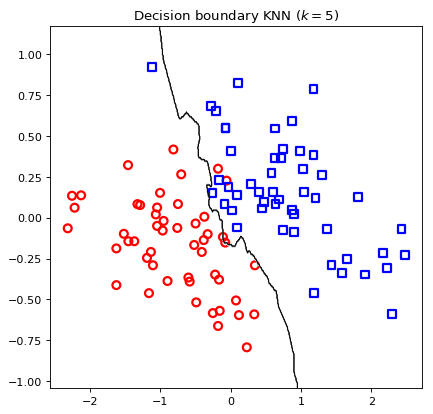

In [5]:
#@title Decision boundary
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Loading some example data
X = D_reduced
y = l

# Training classifiers
knn_classifier = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_classifier.fit(X, y)
# Plotting decision regions
margin = .25
step = .01
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))

Z = knn_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(num=None, figsize=(6,6), dpi=80, facecolor='w', edgecolor='k')

marker_size = 50
plt.contour(xx, yy, Z, cmap='Greys', linewidths=.75);
plt.scatter(X[l == 1,0], X[l == 1,1], marker='o', facecolor='None', linewidth=2, edgecolor='r', s=marker_size);
plt.scatter(X[l == 2,0], X[l == 2,1], marker='s', facecolor='None', linewidth=2, edgecolor='b', s=marker_size);

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title('Decision boundary KNN ($k=5$)')

plt.show();

### Finding hard examples by Vision paper method

* **Positive Examples**: For positive examples, cycles are found in the KNN graph. All edges are then *positive* hard examples.
* **Negative Examples**: Weighted shortest distance in the KNN graph is compared wiith Euiclidean distance in the embedding space. Those with low euclidean space and high shortest path distance are reported as negative examples.

**_NOTE_** From what I understand, the way the Vision paper does the negative example mining is that they just sort pairs by their (weighted) shortest path distance in the KNN graph and then take the top-k instances as *hard examples*. I couldn't find any more info about the specific setting they used for their experiments.

[(97.635679141012503, 47, 37, True, True), (96.412182926111925, 58, 62, True, True), (92.447724627357402, 37, 47, True, True), (49.820887809034879, 22, 6, True, True), (48.417200028827907, 6, 22, True, True), (41.741679490272148, 77, 33, False, True), (41.741679490272148, 33, 77, False, True), (35.499173742429925, 95, 66, True, True), (35.499173742429925, 66, 95, True, True), (31.523187125297422, 30, 14, True, True)]


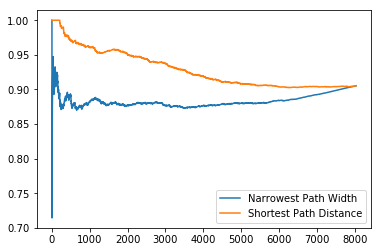

In [35]:
l_pred = knn_classifier.predict(D_reduced)

# Finding all shortest geodesic distances between pairs of nodes
all_shortest_paths = nx.all_pairs_dijkstra_path_length(G)

all_pair_distances = []
# We remove self distance here
for source, shortest_paths in all_shortest_paths.items():
    shortest_paths.pop(source, None)
    for target, distance in shortest_paths.items():
        all_pair_distances.append((
            distance,
            source,
            target,
            l[source] == l[target], # This is class similarity ground truth
            l_pred[source] == l_pred[target] # This is predicted class similarity
        ))


all_pair_distances.sort(reverse=True)

# FOR VISION PAPER NEGATIVES
trues = 0
falses = 0
distance_acc = []

for distance, source, target, sim, pred_sim in all_pair_distances:
    if sim == pred_sim:
        trues += 1
    else:
        falses += 1
    
    distance_acc.append(float(trues) / (trues + falses))
    
all_pair_width = []
for (source, target), width in pair_narrowest_path.items():
    cur_euc_distance = pair_euclidean_distance[(source, target)]
    if cur_euc_distance == 0.0:
        ratio = 1.0
    else:
        ratio = width / cur_euc_distance
    all_pair_width.append((
        ratio,
        source,
        target,
        l[source] == l[target], # This is class similarity ground truth
        l_pred[source] == l_pred[target] # This is predicted class similarity
    ))
all_pair_width.sort(reverse=True)

print(all_pair_width[:10])

# FOR OUR NEGATIVES
trues = 0
falses = 0
width_acc = []

for ratio, source, target, sim, pred_sim in all_pair_width:
    if sim == pred_sim:
        trues += 1
    else:
        falses += 1
    width_acc.append(float(trues) / (trues + falses))

plt.plot(np.arange(1, len(all_pair_width) + 1), width_acc);
plt.plot(np.arange(1, len(all_pair_distances) + 1), distance_acc);

plt.legend(['Narrowest Path Width', 'Shortest Path Distance'], loc='lower right');
plt.show()